In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torchsummary import summary
from types import MethodType
from torchvision.models.resnet import Bottleneck
from sklearn.decomposition import PCA
import os, time, copy, math, random
from pathlib import Path
from torch.optim.lr_scheduler import StepLR
import umap
from tqdm import tqdm

### Baseline Setup

Loading Pretrained ResNet

In [3]:
pretrained_resnet = torchvision.models.resnet152(weights=torchvision.models.ResNet152_Weights.IMAGENET1K_V2)

Downloading CIFAR-10

In [4]:
# Define transform to convert images to tensor and normalize
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# Download CIFAR-10 training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./cifar_data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./cifar_data', train=False, download=True, transform=transform)

In [5]:
trainloader = DataLoader(trainset, batch_size=48, shuffle=True)
testloader = DataLoader(testset, batch_size=48, shuffle=False)

In [6]:
# CLASSES
print(len(trainset.classes))
print(trainset.classes)

10
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Modfying Resnet

In [7]:
# REPLACING FINAL LAYER
pretrained_resnet.fc = torch.nn.Linear(in_features=2048, out_features=10, bias=True) 
# FREEZING BACKBONE
for param in pretrained_resnet.parameters():
    param.requires_grad = False
for param in pretrained_resnet.fc.parameters():
    param.requires_grad = True

Training New Classification Head

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(device)
pretrained_resnet = pretrained_resnet.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_resnet.fc.parameters(), lr=0.005)

cuda


In [50]:
num_epochs = 5
for epoch in (range(num_epochs)):
    pretrained_resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = pretrained_resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_acc = 100. * correct / total
    print(f"Epoch {epoch+1}")
    print(f"\tTraining Loss: {running_loss/len(trainloader):.4f}, Train Acc: {train_acc:.2f}%")

    # Validation
    pretrained_resnet.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = pretrained_resnet(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_acc = 100. * correct / total
    print(f"\tValidation Acc: {val_acc:.2f}%")

Epoch 1
	Training Loss: 0.6466, Train Acc: 78.92%
	Validation Acc: 81.38%
Epoch 2
	Training Loss: 0.5490, Train Acc: 82.60%
	Validation Acc: 83.43%
Epoch 3
	Training Loss: 0.5231, Train Acc: 83.54%
	Validation Acc: 82.71%
Epoch 4
	Training Loss: 0.5232, Train Acc: 83.74%
	Validation Acc: 82.83%
Epoch 5
	Training Loss: 0.5245, Train Acc: 83.67%
	Validation Acc: 82.68%


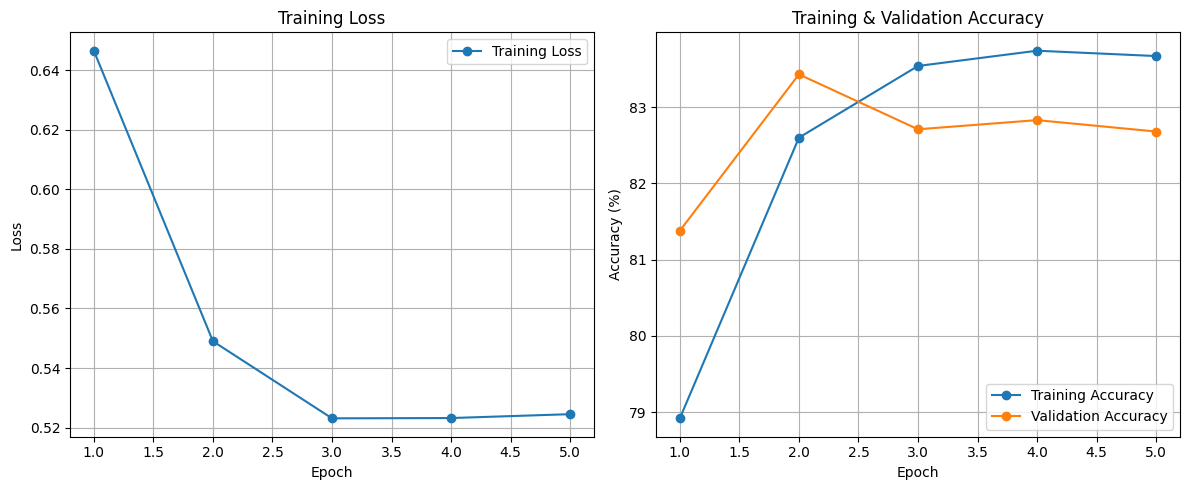

In [51]:
training_losses = [0.6466,0.5490,0.5231,0.5232,0.5245]
training_accuracies = [78.92,82.60,83.54,83.74,83.67]
validation_accuracies = [81.38,83.43,82.71,82.83,82.68]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training loss
axs[0].plot(range(1, num_epochs + 1), training_losses, marker='o', label='Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')
axs[0].grid(True)
axs[0].legend()

# Plot accuracies
axs[1].plot(range(1, num_epochs + 1), training_accuracies, marker='o', label='Training Accuracy')
axs[1].plot(range(1, num_epochs + 1), validation_accuracies, marker='o', label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].set_title('Training & Validation Accuracy')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

### Residual Connections in Practice

In [52]:
def make_forward():
    def forward(self: Bottleneck, x):
        out = self.conv1(x) 
        out = self.bn1(out) 
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)

        out = out
        out = self.relu(out)
        return out
    return forward

targets = [
    ("layer2", 3),   
    ("layer3", 5),
    ("layer4", 0),
]

for layer_name, idx in targets:
    blk = getattr(pretrained_resnet, layer_name)[idx]
    blk.forward = MethodType(make_forward(), blk)

In [53]:
num_epochs = 3
for epoch in range(num_epochs):
    pretrained_resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = pretrained_resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_acc = 100. * correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}, Train Acc: {train_acc:.2f}%")

    # Validation
    pretrained_resnet.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = pretrained_resnet(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_acc = 100. * correct / total
    print(f"Validation Acc: {val_acc:.2f}%")

Epoch 1, Loss: 2.3871, Train Acc: 10.66%
Validation Acc: 10.16%
Epoch 2, Loss: 2.3517, Train Acc: 11.18%
Validation Acc: 10.58%
Epoch 3, Loss: 2.3400, Train Acc: 11.46%
Validation Acc: 11.70%


### Feature Hierarchies and Representations

In [11]:
len(testloader)

209

In [13]:
import torch
from torchvision import models
from sklearn.decomposition import IncrementalPCA
import umap
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = pretrained_resnet.to(device).eval()  # your model

tap_points = {
    "early":  model.layer1[-1],
    "middle": model.layer3[-1],
    "late":   model.layer4[-1],
}

# ---- Pass 1: fit IncrementalPCA on batches (no storing of big features) ----
N_COMP = min(100, testloader.batch_size)   # e.g., 48
ipca = {k: IncrementalPCA(n_components=N_COMP, batch_size=256) for k in tap_points}


def make_fit_hook(name):
    def hook(_m, _inp, out):
        X = out.flatten(1).detach().cpu().numpy() if out.dim()==4 else out.detach().cpu().numpy()
        ipca[name].partial_fit(X)
    return hook

handles = [tap_points[k].register_forward_hook(make_fit_hook(k)) for k in tap_points]
import itertools

with torch.inference_mode():
    for x, _ in itertools.islice(testloader, 3):  # first 3 batches only
        _ = model(x.to(device, non_blocking=True))
for h in handles: h.remove()

# ---- Pass 2: transform to 100D on the fly, store only small matrices -------
buffers_small = {k: [] for k in tap_points}

def make_transform_hook(name):
    def hook(_m, _inp, out):
        X = out.flatten(1).detach().cpu().numpy() if out.dim()==4 else out.detach().cpu().numpy()
        Z = ipca[name].transform(X)          # [B, 100]
        buffers_small[name].append(Z)
    return hook

handles = [tap_points[k].register_forward_hook(make_transform_hook(k)) for k in tap_points]
labels = []
with torch.inference_mode():
    for x, y in testloader:
        _ = model(x.to(device, non_blocking=True))
        labels.append(y)
for h in handles: h.remove()

labels = torch.cat(labels).numpy()
feats100 = {k: np.concatenate(v, axis=0) for k, v in buffers_small.items()}  # [N, 100] each

# ---- UMAP on 100D (much smaller) ------------------------------------------
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="euclidean", random_state=0)
embeddings = {k: reducer.fit_transform(v) for k, v in feats100.items()}  # [N, 2] each


KeyboardInterrupt: 

In [ ]:
def plot_scatter(Z, y, title):
    plt.figure(figsize=(6.5, 5.5))
    # Let matplotlib choose colors; 10 classes -> 10 colors
    for c in np.unique(y):
        idx = (y == c)
        plt.scatter(Z[idx, 0], Z[idx, 1], s=6, alpha=0.7, label=trainset.classes[c])
    plt.legend(markerscale=3, fontsize=8, loc='best', frameon=False)
    plt.title(title)
    plt.xlabel("dim 1"); plt.ylabel("dim 2")
    plt.tight_layout()
    plt.show()

for name, Z in embeddings.items():
    plot_scatter(Z, labels, f"{name.capitalize()} features UMAP")

### Transfer Learning and Generalisation

Train from scratch on CIFAR

In [ ]:
# experiment_resnet152_transfer.py
import os, copy, random, time
from pathlib import Path
from typing import Dict, Tuple, List

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms, models

# =========================
# Utils
# =========================
def set_seed(seed: int = 42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =========================
# Data
# =========================
def build_dataloaders(
    data_dir: str,
    img_size: int = 224,
    batch_size: int = 64,
    num_workers: int = 4,
) -> Tuple[Dict, Dict, List[str], int]:
    """
    Expected structure:
      data_dir/
        train/<class>/*.jpg
        val/<class>/*.jpg
    """
    tfm_train = transforms.Compose([
        transforms.RandomResizedCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
    tfm_val = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])

    image_datasets = {
        "train": datasets.ImageFolder(os.path.join(data_dir, "train"), tfm_train),
        "val":   datasets.ImageFolder(os.path.join(data_dir, "val"), tfm_val),
    }
    loaders = {
        split: torch.utils.data.DataLoader(
            image_datasets[split],
            batch_size=batch_size,
            shuffle=(split=="train"),
            num_workers=num_workers,
            pin_memory=True)
        for split in ["train","val"]
    }
    sizes = {k: len(v) for k, v in image_datasets.items()}
    classes = image_datasets["train"].classes
    num_classes = len(classes)
    return loaders, sizes, classes, num_classes

# =========================
# Model factory
# =========================
def make_model(num_classes: int, init: str):
    """
    init: 'pretrained' or 'scratch'
    """
    assert init in {"pretrained","scratch"}
    weights = models.ResNet152_Weights.IMAGENET1K_V2 if init=="pretrained" else None
    m = models.resnet152(weights=weights)
    in_features = m.fc.in_features
    m.fc = nn.Linear(in_features, num_classes)
    return m

def set_trainable_strategy(model: nn.Module, strategy: str):
    """
    strategy: 'full' or 'final_block'
      - 'full': all layers trainable
      - 'final_block': freeze everything except layer4 and fc
    Returns a list of parameter groups for the optimizer.
    """
    assert strategy in {"full","final_block"}
    # First, freeze everything
    for p in model.parameters():
        p.requires_grad = False

    if strategy == "full":
        for p in model.parameters():
            p.requires_grad = True
        # single param group
        params = [{"params": model.parameters()}]
    else:
        # Unfreeze only layer4 + fc
        for p in model.layer4.parameters():
            p.requires_grad = True
        for p in model.fc.parameters():
            p.requires_grad = True
        # You can give head a slightly higher LR if desired; keep same for fairness here
        params = [
            {"params": model.layer4.parameters()}, 
            {"params": model.fc.parameters()}
        ]
    return params

# =========================
# Train / Eval
# =========================
@torch.no_grad()
def evaluate(model: nn.Module, loader, criterion):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss = criterion(logits, y)
        pred = logits.argmax(dim=1)
        loss_sum += loss.item() * x.size(0)
        correct  += (pred == y).sum().item()
        total    += x.size(0)
    return loss_sum/total, correct/total

def train_one(
    model: nn.Module,
    loaders: Dict,
    max_epochs: int = 15,
    base_lr: float = 1e-3,
    step_size: int = 7,
    gamma: float = 0.1,
    params_override=None,
):
    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()

    if params_override is None:
        optimizer = optim.SGD(model.parameters(), lr=base_lr, momentum=0.9)
    else:
        optimizer = optim.SGD(params_override, lr=base_lr, momentum=0.9)

    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

    best = {"val_acc": 0.0, "epoch": -1, "state": copy.deepcopy(model.state_dict())}
    for epoch in range(max_epochs):
        model.train()
        run_loss, run_corrects, n = 0.0, 0, 0

        for x, y in loaders["train"]:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            pred = logits.argmax(dim=1)
            run_loss     += loss.item() * x.size(0)
            run_corrects += (pred == y).sum().item()
            n            += x.size(0)

        train_loss = run_loss / n
        train_acc  = run_corrects / n

        val_loss, val_acc = evaluate(model, loaders["val"], criterion)
        scheduler.step()

        print(f"Epoch {epoch:02d}: "
              f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
              f"val_loss={val_loss:.4f} acc={val_acc:.4f}")

        if val_acc > best["val_acc"]:
            best["val_acc"] = val_acc
            best["epoch"]   = epoch
            best["state"]   = copy.deepcopy(model.state_dict())

    # restore best
    model.load_state_dict(best["state"])
    return best

# =========================
# Experiment runner (b + c)
# =========================
def run_experiments(
    data_dir: str,
    img_size: int = 224,
    batch_size: int = 64,
    num_workers: int = 4,
    epochs: int = 15,
    base_lr: float = 1e-3,
):
    set_seed(42)
    loaders, sizes, classes, num_classes = build_dataloaders(
        data_dir, img_size, batch_size, num_workers
    )
    print(f"Classes ({num_classes}): {classes}")

    configs = [
        {"init":"pretrained", "strategy":"full"},
        {"init":"pretrained", "strategy":"final_block"},
        {"init":"scratch",    "strategy":"full"},
        {"init":"scratch",    "strategy":"final_block"},
    ]

    results = []
    for cfg in configs:
        print("\n" + "="*60)
        print(f"Config: init={cfg['init']} | strategy={cfg['strategy']}")
        print("="*60)

        model = make_model(num_classes, init=cfg["init"])
        param_groups = set_trainable_strategy(model, strategy=cfg["strategy"])
        best = train_one(
            model,
            loaders,
            max_epochs=epochs,
            base_lr=base_lr,
            params_override=param_groups
        )
        # Save checkpoint for each run
        Path("checkpoints").mkdir(exist_ok=True)
        ckpt_name = f"resnet152_{cfg['init']}_{cfg['strategy']}.pt"
        torch.save(model.state_dict(), f"checkpoints/{ckpt_name}")
        print(f"Saved: checkpoints/{ckpt_name}")

        results.append({
            "init": cfg["init"],
            "strategy": cfg["strategy"],
            "best_val_acc": best["val_acc"],
            "best_epoch": best["epoch"],
        })

    # Summary table
    print("\n==== Summary (higher is better) ====")
    print(f"{'init':<12} {'strategy':<12} {'best_acc':>9} {'epoch':>7}")
    for r in results:
        print(f"{r['init']:<12} {r['strategy']:<12} {r['best_val_acc']:>9.4f} {r['best_epoch']:>7d}")

if __name__ == "__main__":
    # CHANGE THIS to your dataset root (not ImageNet). Example mirrors PyTorch tutorial layout.
    DATA_DIR = "data/hymenoptera_data"   # e.g., ants & bees tutorial dataset
    run_experiments(
        data_dir=DATA_DIR,
        img_size=224,
        batch_size=64,
        num_workers=4,
        epochs=15,
        base_lr=1e-3,
    )